In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
%matplotlib inline

## connect to database

In [5]:
#In Python: Define a database name (we're using a dataset on births, so I call it 
# birth_db), and your username for your computer (CHANGE IT BELOW). 
dbname = 'music_db'
username = 'shayneufeld'

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://shayneufeld@localhost/music_db


# retrieve spotify table, bandcamp table, and sales table

In [295]:
#bandcamp table
sql_query = """
SELECT * FROM bandcamp_table;
"""
bandcamp_table = pd.read_sql_query(sql_query,con)
print('bandcamp_table has %.0f rows' % bandcamp_table.shape[0])

#spotify table
sql_query = """
SELECT * FROM spotify_table WHERE match=True;
"""
spotify_table = pd.read_sql_query(sql_query,con)

#sales table
sql_query = """
SELECT * FROM sales_table;
"""
sales_table = pd.read_sql_query(sql_query,con)

bandcamp_table has 1520438 rows


In [301]:
#drop duplicated values
bandcamp_table = bandcamp_table.drop_duplicates()
bandcamp_table.shape

(471754, 5)

In [302]:
spotify_table.head(2)

,index,Unnamed: 0.1,Unnamed: 0.1.1,artist_genres,artist_id,artist_name,artist_spotify_url,artist_total_followers,bc_artist_name,match,popularity,related_artists_sp
0,2,2.0,0.0,['deep psytrance'],4mcgQslFqVoXe78ADfBoLX,Whitebear,https://open.spotify.com/artist/4mcgQslFqVoXe7...,3264,Whitebear,True,27,"['Mr. Bill', 'Bumble', 'Kalya Scintilla', 'SIX..."
1,4,4.0,0.0,none,43YBvuW0iMYrQlpSsJJQWp,We Were Friends,https://open.spotify.com/artist/43YBvuW0iMYrQl...,69,We Were Friends,True,3,"['Matt Steele', 'Flowerpot Press', 'The Auspic..."


In [303]:
# drop the index + 2 unnamed columns
cols = spotify_table.columns.values
spotify_table = spotify_table.drop(cols[:3],axis=1)
spotify_table.head(2)

,artist_genres,artist_id,artist_name,artist_spotify_url,artist_total_followers,bc_artist_name,match,popularity,related_artists_sp
0,['deep psytrance'],4mcgQslFqVoXe78ADfBoLX,Whitebear,https://open.spotify.com/artist/4mcgQslFqVoXe7...,3264,Whitebear,True,27,"['Mr. Bill', 'Bumble', 'Kalya Scintilla', 'SIX..."
1,none,43YBvuW0iMYrQlpSsJJQWp,We Were Friends,https://open.spotify.com/artist/43YBvuW0iMYrQl...,69,We Were Friends,True,3,"['Matt Steele', 'Flowerpot Press', 'The Auspic..."


In [304]:
sales_table.head(2)

,index,addl_count,album_title,amount_over_fmt,amount_paid,amount_paid_fmt,amount_paid_usd,art_id,art_url,artist_name,...,item_description,item_price,item_slug,item_type,package_image_id,releases,slug_type,track_album_slug_text,url,utc_date
0,0,NaN,S/T,None,7.0,$7,7.0,NaN,//f4.bcbits.com/img/0010845335_37.jpg,SIDDIQ,...,LIMITED CASSETTE ACTION!,7.0,None,p,10845335.0,NaN,a,None,//illuminatedpaths.bandcamp.com/album/s-t-7,1.500604e+09
1,0,NaN,None,None,5.0,$5,5.0,1.960132e+09,//f4.bcbits.com/img/a1960131950_7.jpg,EGYPT,...,ENDLESS FLIGHT,5.0,None,a,NaN,NaN,a,None,//egypt1.bandcamp.com/album/endless-flight,1.500604e+09


In [305]:
# drop extra index row
sales_table = sales_table.drop('index',axis=1)
sales_table.head(2)

,addl_count,album_title,amount_over_fmt,amount_paid,amount_paid_fmt,amount_paid_usd,art_id,art_url,artist_name,country,...,item_description,item_price,item_slug,item_type,package_image_id,releases,slug_type,track_album_slug_text,url,utc_date
0,NaN,S/T,None,7.0,$7,7.0,NaN,//f4.bcbits.com/img/0010845335_37.jpg,SIDDIQ,United States,...,LIMITED CASSETTE ACTION!,7.0,None,p,10845335.0,NaN,a,None,//illuminatedpaths.bandcamp.com/album/s-t-7,1.500604e+09
1,NaN,None,None,5.0,$5,5.0,1.960132e+09,//f4.bcbits.com/img/a1960131950_7.jpg,EGYPT,United States,...,ENDLESS FLIGHT,5.0,None,a,NaN,NaN,a,None,//egypt1.bandcamp.com/album/endless-flight,1.500604e+09


# The plan

## the database
for each artist in `spotify_table`:
    - get # spotify followers
    - get spotify genres
    
    - look up that artist in the `bandcamp_table`:
        - get # total BC supporters
        - get avg # supporters per album
        - get # BC albums
    - look up that artist in `sales_table`:
        - get total revenue
        - get total # sales
        - then break it down for a,p,t,b: #sales, average price, total revenue

## MVP

1. input: artist name
2. search database for artists with similar # of followers & at least 1 shared genre
3. for those artists, return average values for all the other columns

In [306]:
artists = spotify_table.artist_name.unique()
print('There are %.0f artists to parse through' % artists.shape[0])

There are 13737 artists to parse through


In [307]:
spotify_table.head(2)

,artist_genres,artist_id,artist_name,artist_spotify_url,artist_total_followers,bc_artist_name,match,popularity,related_artists_sp
0,['deep psytrance'],4mcgQslFqVoXe78ADfBoLX,Whitebear,https://open.spotify.com/artist/4mcgQslFqVoXe7...,3264,Whitebear,True,27,"['Mr. Bill', 'Bumble', 'Kalya Scintilla', 'SIX..."
1,none,43YBvuW0iMYrQlpSsJJQWp,We Were Friends,https://open.spotify.com/artist/43YBvuW0iMYrQl...,69,We Were Friends,True,3,"['Matt Steele', 'Flowerpot Press', 'The Auspic..."


In [341]:
artist

'Glass Machines'

In [340]:
np.where(artists == artist)

(array([11129]),)

In [342]:
spotify_table.loc[spotify_table.artist_name==artist,'artist_total_followers'] = 2

In [343]:
for artist in artists[11129:]:
    #retrieve record in spotify_table
    sp = spotify_table[spotify_table.artist_name == artist]
    
    #get relevant information from spotify_table
    sp_follows = sp.artist_total_followers.values[0]
    sp_genres = sp.artist_genres
    sp_related_artists = sp.related_artists_sp.values[0]
    sp_popularity = sp.popularity
    
    #retrieve sales records for that artist
    bc_name = sp.artist_name.values[0]
    
    sales = sales_table[sales_table.artist_name == bc_name]
    
    #get info on total sales
    total_revenue = sales.amount_paid_usd.sum()
    total_sales = sales.shape[0]
    total_avgprice = sales.amount_paid_usd.mean()
    
    #get info on different product types
    a_total_revenue = sales[sales.item_type == 'a'].amount_paid_usd.sum()
    a_total_sales =sales[sales.item_type == 'a'].shape[0]
    a_avgprice = sales[sales.item_type == 'a'].amount_paid_usd.mean()
    
    p_total_revenue = sales[sales.item_type == 'p'].amount_paid_usd.sum()
    p_total_sales =sales[sales.item_type == 'p'].shape[0]
    p_avgprice = sales[sales.item_type == 'p'].amount_paid_usd.mean()
    
    t_total_revenue = sales[sales.item_type == 't'].amount_paid_usd.sum()
    t_total_sales =sales[sales.item_type == 't'].shape[0]
    t_avgprice = sales[sales.item_type == 't'].amount_paid_usd.mean()
    
    b_total_revenue = sales[sales.item_type == 'b'].amount_paid_usd.sum()
    b_total_sales =sales[sales.item_type == 'b'].shape[0]
    b_avgprice = sales[sales.item_type == 'b'].amount_paid_usd.mean()
    
    #retrieve bandcamp_table info
    bandcamp = bandcamp_table[bandcamp_table.artist_name == bc_name]
    
    if bandcamp.shape[0]==0:
        bc_name_adj = '[' + bc_name + ']'
        bandcamp = bandcamp_table[bandcamp_table.artist_name == bc_name_adj]
    
    if bandcamp.shape[0]==0:
        not_found.append(bc_name)
        bc_total_supporters = None
        bc_num_albums = None
        bc_avg_supporters = None
    else:
        bc_total_supporters = bandcamp.shape[0]
        bc_num_albums = bandcamp.album_url.unique().shape[0]
        bc_avg_supporters = bandcamp.shape[0] / bc_num_albums

    d = {
        'sp_artist': artist,
        'bc_artist': bc_name,
        'sp_num_followers': int(sp_follows),
        'sp_popularity': int(sp_popularity.values[0]),
        'sp_genres': sp_genres.values[0],
        'sp_related_artists':sp_related_artists,
        'bc_num_supporters': bc_total_supporters,
        'bc_avg_supporters': bc_avg_supporters,
        'bc_num_albums': bc_num_albums,
        'sales_total_revenue': total_revenue,
        'sales_total_sales': total_sales,
        'sales_avgprice': total_avgprice,
        'sales_album_dl_revenue': a_total_revenue,
        'sales_album_dl_sales': a_total_sales,
        'sales_album_dl_avgprice': a_avgprice,
        'sales_album_p_revenue': p_total_revenue,
        'sales_album_p_sales': p_total_sales,
        'sales_album_p_avgprice': p_avgprice,
        'sales_track_dl_revenue': t_total_revenue,
        'sales_track_dl_sales': t_total_sales,
        'sales_track_dl_avgprice': t_avgprice,
        'sales_bundle_revenue': b_total_revenue,
        'sales_bundle_sales': b_total_sales,
        'sales_bundle_avgprice': b_avgprice
    }

    master_table = master_table.append(pd.DataFrame(data=d,index=[0]))
    master_table.to_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/master_table.csv')

In [344]:
master_table.shape

(13737, 24)

## add master_table to db (this was done aft

In [3]:
master_table = pd.read_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/master_table.csv')

In [6]:
master_table.to_sql('artist_summary_table', engine, if_exists='replace')

## add trimmed data (only artists with sales data and spotify genres)

In [8]:
data_trimmed = master_table[master_table.sp_genres != 'none']
data_trimmed = data_trimmed[~data_trimmed.bc_num_albums.isnull()]
data_trimmed.to_sql('artist_table_trimmed',engine,if_exists='replace')

<50 - 477
50:500 - 431
>500 - 129


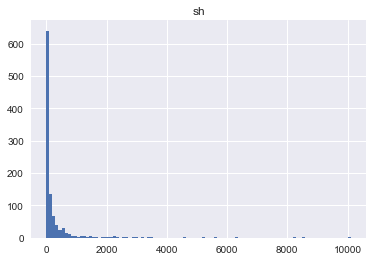

In [31]:
plt.hist(data_trimmed.bc_num_supporters.values,bins=100)
plt.title('sh')

small = data_trimmed[data_trimmed.bc_num_supporters < 50].shape[0]
large = data_trimmed[data_trimmed.bc_num_supporters > 500].shape[0]
med = data_trimmed.shape[0] - small - large

print('<50 - %.0f' % small)
print('50:500 - %.0f' % med)
print('>500 - %.0f' % large)

In [22]:
data_trimmed.to_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/master_table_trimmed.csv')

In [20]:
data_trimmed.bc_avg_supporters.sort_values(ascending=False).values
popular_artists_inds = data_trimmed.bc_avg_supporters.sort_values(ascending=False).index.values
popular_artists = data_trimmed.loc[popular_artists_inds,'bc_artist']
d = {'artist':popular_artists,'num_followers':data_trimmed.bc_avg_supporters.sort_values(ascending=False).values}
pd.DataFrame(data=d)

,artist,num_followers
7642,bl00dwave,4612.000000
46,Mystery Skulls,4274.500000
4133,Riverwave 川の波,3375.000000
8260,Dan Mason ダン·メイソン,2841.000000
901,Yussef Kamaal,2666.000000
250,FM-84,2590.000000
965,Carpenter Brut,2589.500000
1519,Cloudkicker,2284.000000
582,Sufjan Stevens,2051.750000
776,JD senuTi,2004.000000


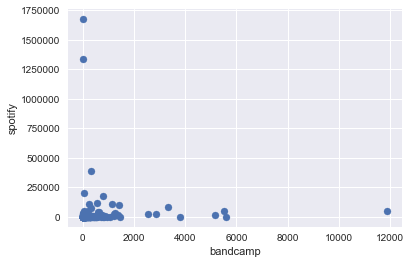

In [247]:
plt.scatter(master_table.bc_num_supporters.values,master_table.sp_num_followers)
plt.xlabel('bandcamp')
plt.ylabel('spotify')

plt.scatter(master_table.sp_num_followers,master_table.sales_total_revenue.values)

In [183]:
int(sp.artist_total_followers.values[0])

185657

In [253]:
num_supporters = master_table[master_table.bc_num_supporters = None].bc_num_supporters.values

In [261]:
master_table[master_table.bc_num_supporters == None]

,bc_artist,bc_avg_supporters,bc_num_albums,bc_num_supporters,sales_album_dl_avgprice,sales_album_dl_revenue,sales_album_dl_sales,sales_album_p_avgprice,sales_album_p_revenue,sales_album_p_sales,...,sales_total_revenue,sales_total_sales,sales_track_dl_avgprice,sales_track_dl_revenue,sales_track_dl_sales,sp_artist,sp_genres,sp_num_followers,sp_popularity,sp_related_artists


In [277]:
num_supporters = master_table.bc_num_supporters.values[master_table.bc_num_supporters.values != None]

(array([ 196.,   22.,   13.,    7.,    2.,    5.,    1.,    0.,    0.,
           0.,    1.,    0.,    1.,    1.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    1.,    0.,    2.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([  1.00000000e+00,   2.38760000e+02,   4.76520000e+02,
          7.14280000e+02,   9.52040000e+02,   1.18980000e+03,
          1.42756000e+03,   1.66532000e+03,   1.90308000e+03,
          2.14084000e+03,   2.37860000e+03,   2.61636000e+03,
          2.85412000e+03,   3.09188000e+03,   3.32964000e+03,
          3.56740000e+03,   3.80516000e+03,   4.04292000e+03,
          4.28068000e+03,   4.51844000e+03,   4.75620000e+03,
          4.99396000e+03,   5.23172000e+03,   5.46948000e+03,
          5.70724000e+03,   5.94500000e+03,   6.18276000e+03,
          6.42052000e+03,   6.65828000e+03

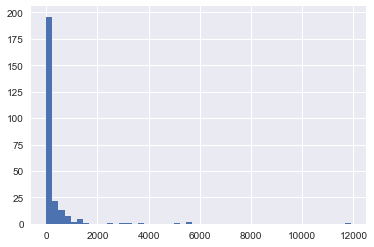

In [280]:
plt.hist(num_supporters,bins=50)